# Explanation

With my wifi 6 router update, I have issues with squeezebox radios not able to connect anymore to wifi.

Even connecting to the legacy router is an issue.

I have posted messages to squeezebox forums : https://forums.slimdevices.com/showthread.php?97791-Squeezebox-Radio-keeps-losing-wireless-connection-and-won-t-reconnect-any-ideas/page10

On user has developped a logging approach to keep track of connectivity issues. My intent is to plot results of these log files.

I have 2 radios, one in the kitchen, one in the bathroom.


# Refresh data from squeezebox server

In [1]:
!mkdir -p data
!mkdir -p plot

scp within jupyter notebook requires to deploy a ssh-key on the target machine.

``` bash
(base) explore@explore-ThinkPad-P53:~/git/guillaume/squeezebox$ ssh-keygen -t rsa
(base) explore@explore-ThinkPad-P53:~/git/guillaume/squeezebox$ scp /home/explore/.ssh/id_rsa.pub guillaume@htpc:~ 
```

``` bash
guillaume@htpc-arctic:~$ cat $HOME/id_rsa.pub >> $HOME/.ssh/authorized_keys
guillaume@htpc-arctic:~$ rm id_rsa.pub
```

In [2]:
# !scp -r guillaume@htpc:wlanpoke/* data/

# move from scp to rsync
!rsync -azvh guillaume@htpc:wlanpoke/* data/

receiving incremental file list


1121.log



sent 6.91K bytes  received 271.75K bytes  61.92K bytes/sec
total size is 353.44M  speedup is 1,268.38


# Read files and turn them into pandas

In [3]:
infile = r"data/1121.log-20201211"

results = []
to_keep = [" ping failed "]

with open(infile) as f:
    f = f.readlines()

for line in f:
    for phrase in to_keep:
        if phrase in line:
            results.append(line)
            break

print(len(results))
for line in results[:3]:
    print(line)
# print(results[:10])

260
2020-12-10T00:07:06+0100 Squeezebox SdB.253_063 192.168.50.1  ping failed eth1 AR6000 802.11g ESSID:"MUSIC" Mode:Managed Frequency:2.412 GHz Access Point: 28:C6:8E:B3:D4:BD Bit Rate=1 Mb/s Tx-Power=15 dBm Sensitivity=0/3 Retry:on Encryption key:off Link Quality:38/94 Signal level:-57 dBm Noise level:-96 dBm Rx invalid nwid:0 Rx invalid crypt:0 Rx invalid frag:0 Tx excessive retries:5 Invalid misc:0 Missed beacon:0

2020-12-10T01:02:07+0100 Squeezebox SdB.253_063 192.168.50.1  ping failed eth1 AR6000 802.11g ESSID:"MUSIC" Mode:Managed Frequency:2.412 GHz Access Point: 28:C6:8E:B3:D4:BD Bit Rate=1 Mb/s Tx-Power=15 dBm Sensitivity=0/3 Retry:on Encryption key:off Link Quality:38/94 Signal level:-57 dBm Noise level:-96 dBm Rx invalid nwid:0 Rx invalid crypt:0 Rx invalid frag:0 Tx excessive retries:9 Invalid misc:0 Missed beacon:0

2020-12-10T01:11:53+0100 Squeezebox SdB.253_063 192.168.50.1  ping failed eth1 AR6000 802.11g ESSID:"MUSIC" Mode:Managed Frequency:2.412 GHz Access Point: 28:

In [4]:
import os
indirectory = r"data/"

results = []
to_keep = [" ping failed "]

for filename in os.listdir(indirectory):
    if filename.startswith("1121.log-"):
        print(os.path.join(indirectory, filename))
        with open(os.path.join(indirectory, filename)) as f:
            f = f.readlines()

            for line in f:
                for phrase in to_keep:
                    if phrase in line:
                        results.append(line)
                        break
            
print(len(results))
for line in results[:3]:
    print(line)


splitted_results = [l.split(' ') for l in results]

data/1121.log-20201225


data/1121.log-20201222


data/1121.log-20201211
data/1121.log-20201214
data/1121.log-20201231
data/1121.log-20201219
data/1121.log-20201218
data/1121.log-20201230
data/1121.log-20201227
data/1121.log-20201212
data/1121.log-20201213
data/1121.log-20201223


data/1121.log-20201216


data/1121.log-20201224


data/1121.log-20201226


data/1121.log-20201217
data/1121.log-20201215
data/1121.log-20201220
data/1121.log-20201221
6103
2020-12-24T06:01:42+0100 Squeezebox Cuisine.252_063 192.168.50.1  ping failed eth1 AR6000 802.11g ESSID:"MUSIC" Mode:Managed Frequency:2.412 GHz Access Point: 28:C6:8E:B3:D4:BD Bit Rate=1 Mb/s Tx-Power=15 dBm Sensitivity=0/3 Retry:on Encryption key:off Link Quality:28/94 Signal level:-67 dBm Noise level:-96 dBm Rx invalid nwid:0 Rx invalid crypt:0 Rx invalid frag:0 Tx excessive retries:4 Invalid misc:0 Missed beacon:0

2020-12-24T06:07:33+0100 Squeezebox Cuisine.252_063 192.168.50.1  ping failed eth1 AR6000 802.11g ESSID:"MUSIC" Mode:Managed Frequency:2.412 GHz Access Point: 28:C6:8E:B3:D4:BD Bit Rate=36 Mb/s Tx-Power=15 dBm Sensitivity=0/3 Retry:on Encryption key:off Link Quality:27/94 Signal level:-68 dBm Noise level:-96 dBm Rx invalid nwid:0 Rx invalid crypt:0 Rx invalid frag:0 Tx excessive retries:2 Invalid misc:0 Missed beacon:0

2020-12-24T06:11:11+0100 Squeezebox SdB.253_063 192.168.

In [5]:
import pandas as pd

raw_logs = pd.DataFrame(splitted_results)
raw_logs = raw_logs[[0, 2]]

raw_logs.columns = ['Date', 'Radio']




raw_logs['Date'] = pd.to_datetime(raw_logs['Date'].str[:-6])

raw_logs['Radio']=raw_logs['Radio'].map({'SdB.253_063': 'BathRoom', 'Cuisine.252_063': 'Kitchen', 'BathRoom':'BathRoom', 'Kitchen':'Kitchen'})
raw_logs['Radio']=raw_logs['Radio'].astype('category')

print(raw_logs['Radio'].value_counts())

squeezeradio_logs = raw_logs.copy()

grp = squeezeradio_logs.groupby(by=[squeezeradio_logs.Date.map(lambda x : (x.year, x.month, x.day, x.hour)), squeezeradio_logs.Radio])
squeezeradio_logs_grouped = grp.count().unstack()
squeezeradio_logs_grouped.columns= squeezeradio_logs_grouped.columns.droplevel()


def reset_index(df):
  '''Returns DataFrame with index as columns'''
  index_df = df.index.to_frame(index=False)
  df = df.reset_index(drop=True)
  #  In merge is important the order in which you pass the dataframes
  # if the index contains a Categorical. 
  # pd.merge(df, index_df, left_index=True, right_index=True) does not work
  return pd.merge(index_df, df, left_index=True, right_index=True)

import numpy as np

squeezeradio_logs_grouped = reset_index(squeezeradio_logs_grouped)
squeezeradio_logs_grouped = squeezeradio_logs_grouped.replace(np.nan, 0)


squeezeradio_logs_grouped['BathRoom']=squeezeradio_logs_grouped['BathRoom'].astype(int)
squeezeradio_logs_grouped['Kitchen']=squeezeradio_logs_grouped['Kitchen'].astype(int)

from datetime import datetime
import time

def tuple_to_date(tup):
    end_tuple = (0,0,0,0,0)
    t = time.mktime(tup+end_tuple)
    return time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(t))

squeezeradio_logs_grouped['Date']=squeezeradio_logs_grouped['Date'].apply(tuple_to_date)
squeezeradio_logs_grouped['Date']= pd.to_datetime(squeezeradio_logs_grouped['Date'])
squeezeradio_logs_grouped.set_index('Date', inplace=True)

#remove fake 1st date 2020-12-09 (investigate later why this is in this file)
import datetime
squeezeradio_logs_grouped = squeezeradio_logs_grouped[squeezeradio_logs_grouped.index.date != datetime.date(2020,12,9)]

new_index = pd.date_range(squeezeradio_logs_grouped.index[0], 
              squeezeradio_logs_grouped.index[-1],
              freq="1H")

squeezeradio_logs_grouped=squeezeradio_logs_grouped.reindex(new_index)
squeezeradio_logs_grouped=squeezeradio_logs_grouped.fillna(0)
squeezeradio_logs_grouped.index.name='Date'
squeezeradio_logs_grouped

Kitchen     3175
BathRoom    2928
Name: Radio, dtype: int64


,BathRoom,Kitchen
Date,,
2020-12-10 00:00:00,7.0,0.0
2020-12-10 01:00:00,7.0,0.0
2020-12-10 02:00:00,8.0,0.0
2020-12-10 03:00:00,7.0,0.0
2020-12-10 04:00:00,7.0,0.0
...,...,...
2020-12-30 11:00:00,0.0,0.0
2020-12-30 12:00:00,0.0,0.0
2020-12-30 13:00:00,0.0,0.0


# Bar Plot errors per month, day, hour

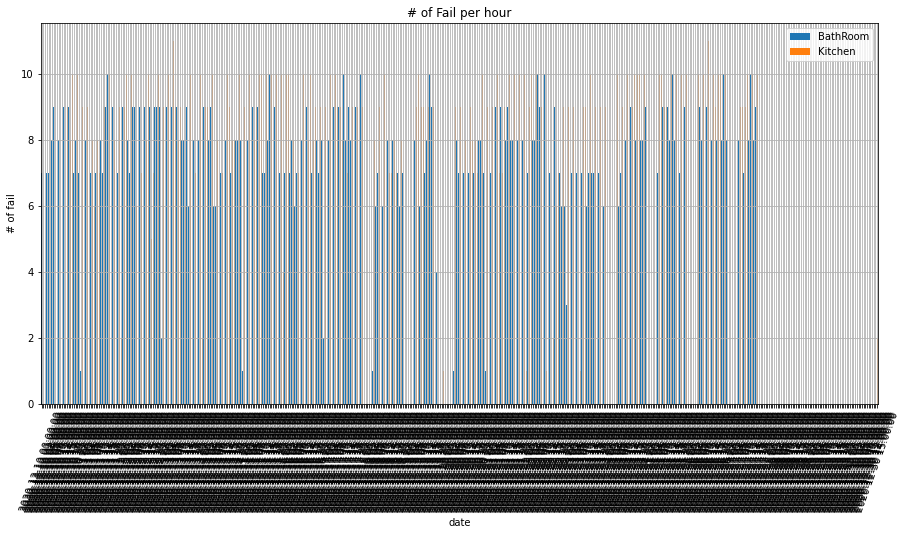

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot data
fig, ax = plt.subplots(figsize=(15,7))



squeezeradio_logs_grouped.plot.bar(rot=70, ax=ax)
plt.xlabel('date')
plt.ylabel('# of fail')
plt.title('# of Fail per hour')
plt.grid(True)

# Simple plot

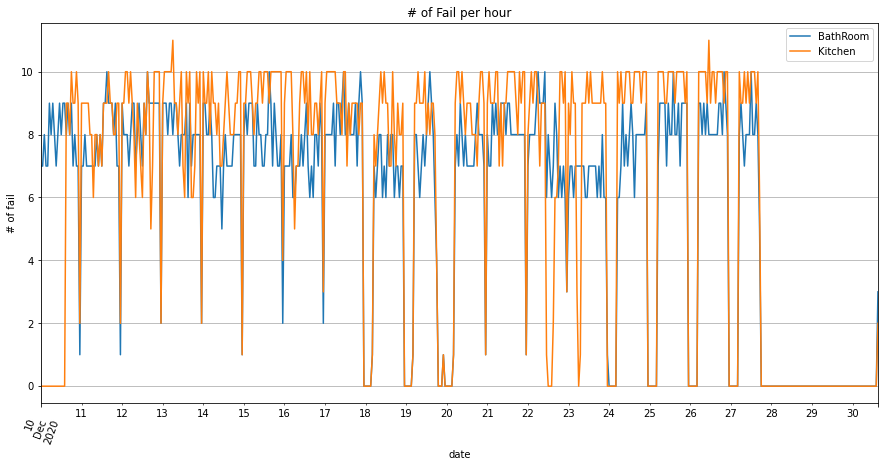

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot data
fig, ax = plt.subplots(figsize=(15,7))



squeezeradio_logs_grouped.plot(ax=ax)
plt.xlabel('date')
plt.ylabel('# of fail')
plt.title('# of Fail per hour')
plt.grid(True)
plt.xticks(rotation=70);

# save plot as png

In [8]:
min_date, max_date = squeezeradio_logs_grouped.reset_index()['Date'].min(), squeezeradio_logs_grouped.reset_index()['Date'].max()
min_date = min_date.strftime("%y%m%d")
max_date = max_date.strftime("%y%m%d")

filename=max_date+'-'+min_date+'.png'
fig.savefig('plot/'+filename)



# Simple daily plots

2020-12-10


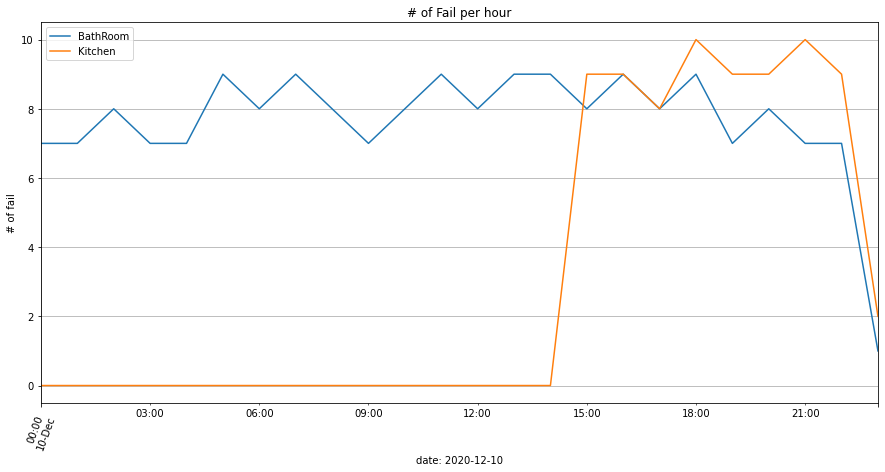

2020-12-11


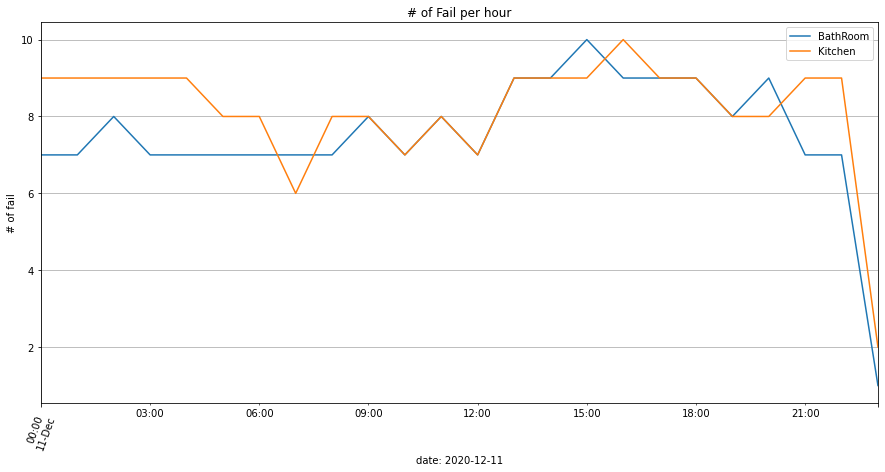

2020-12-12


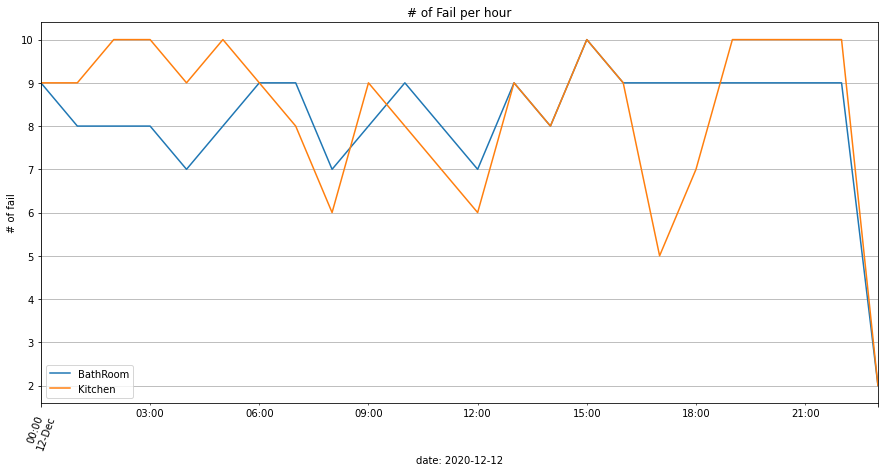

2020-12-13


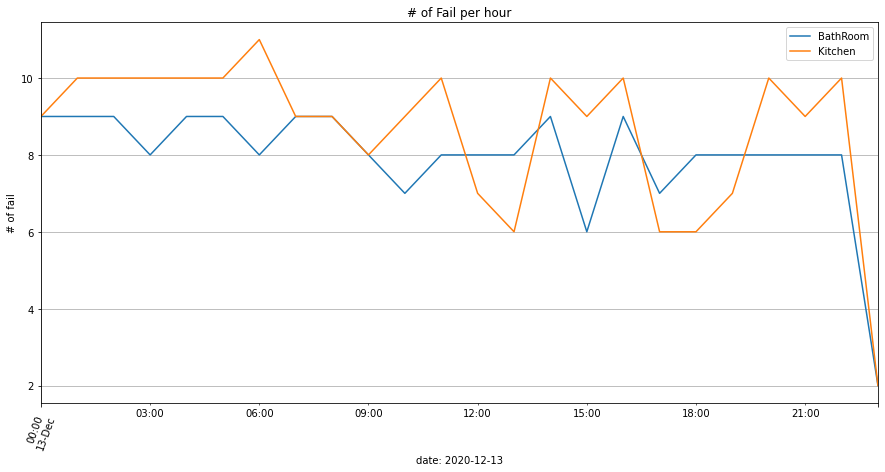

2020-12-14


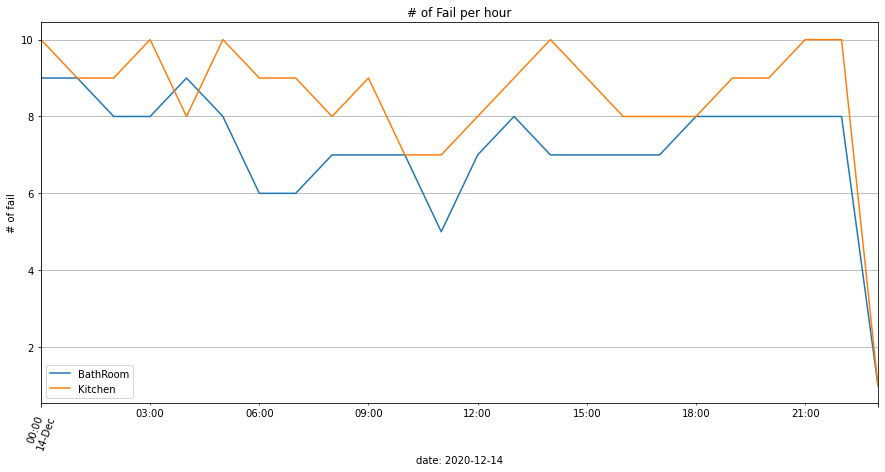

2020-12-15


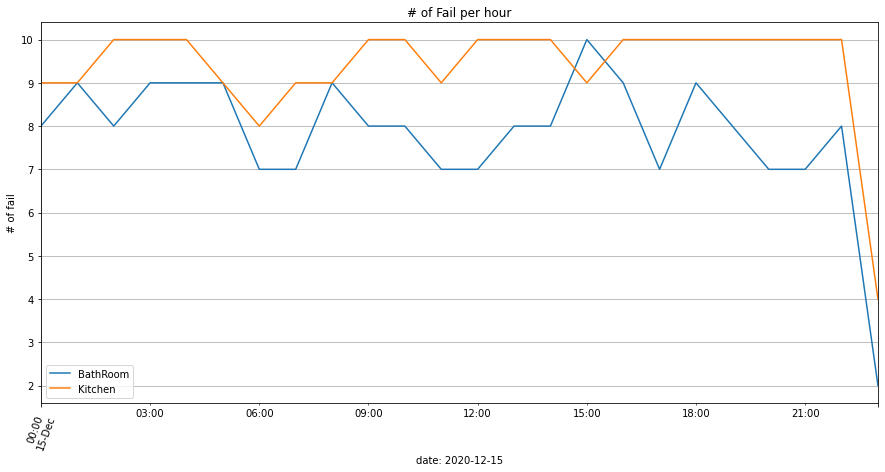

2020-12-16


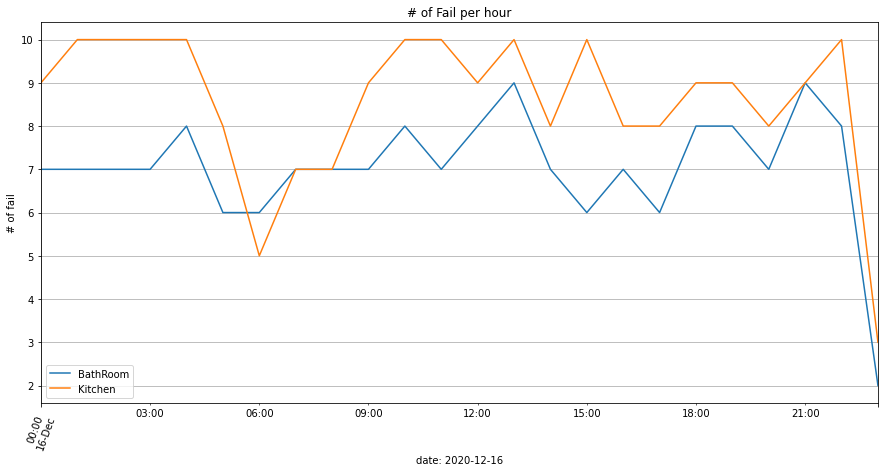

2020-12-17


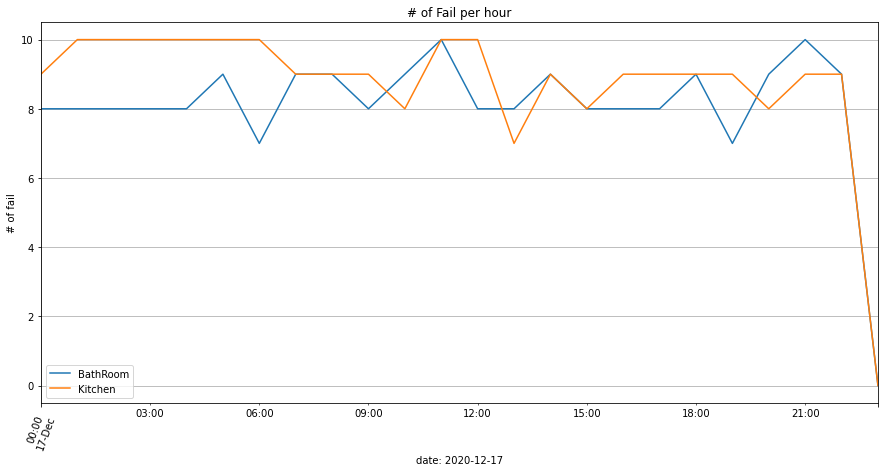

2020-12-18


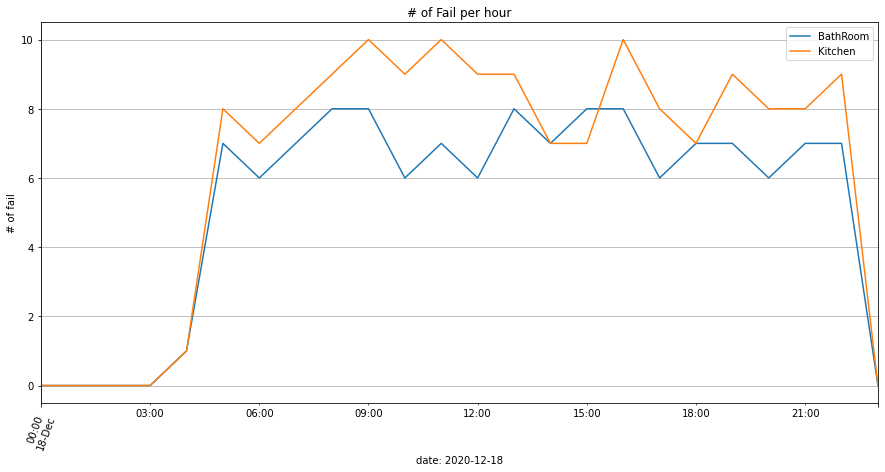

2020-12-19


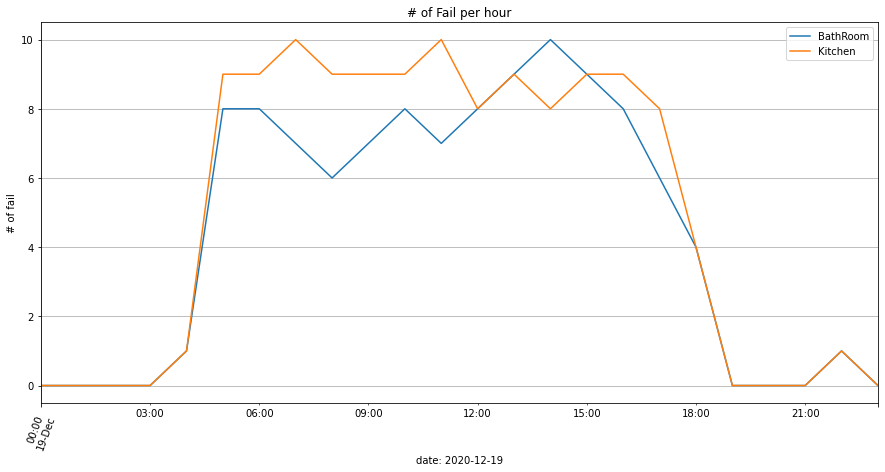

2020-12-20


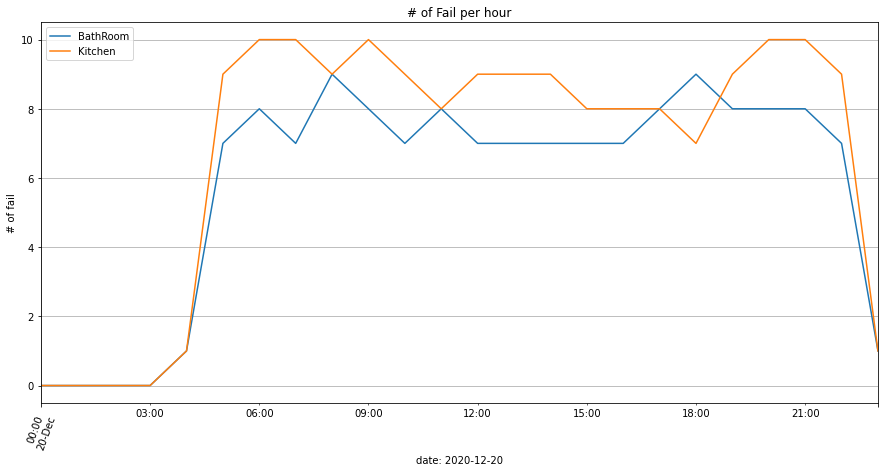

2020-12-21


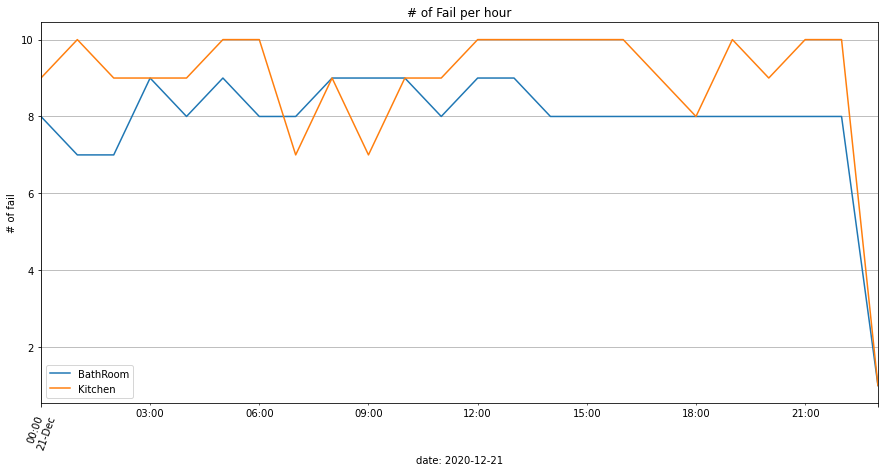

2020-12-22


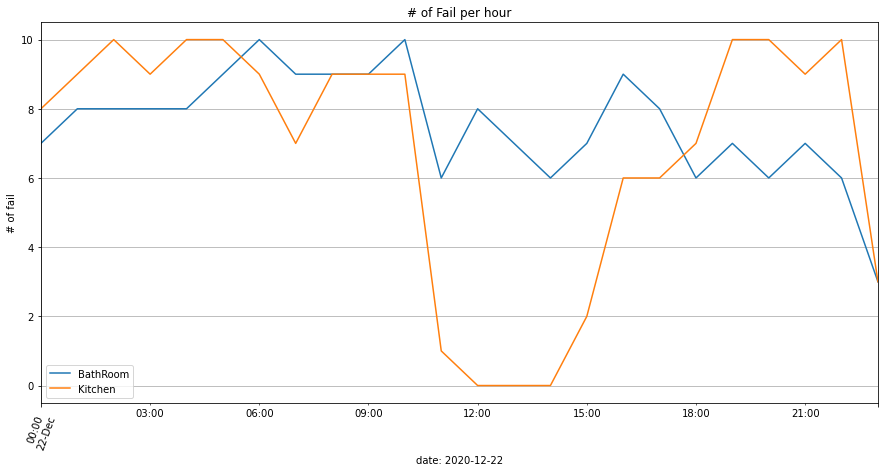

2020-12-23


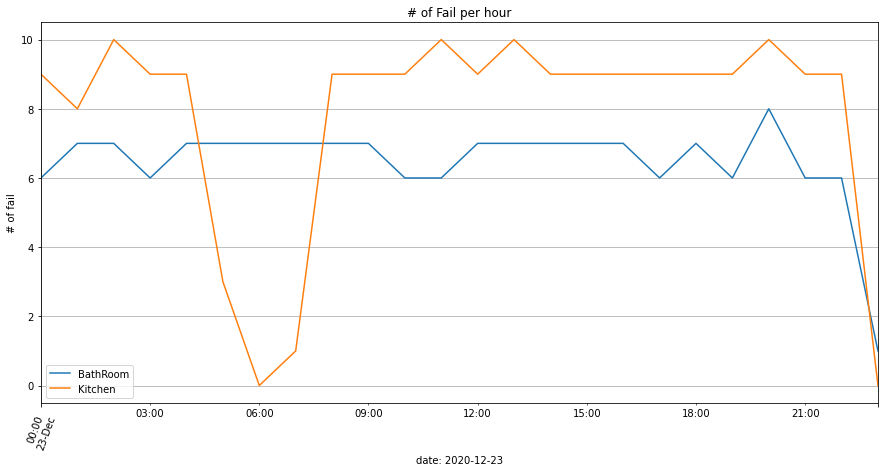

2020-12-24


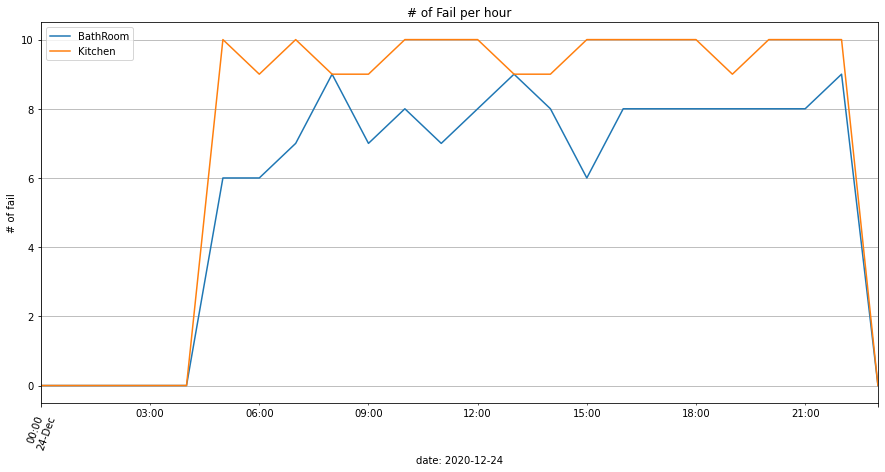

2020-12-25


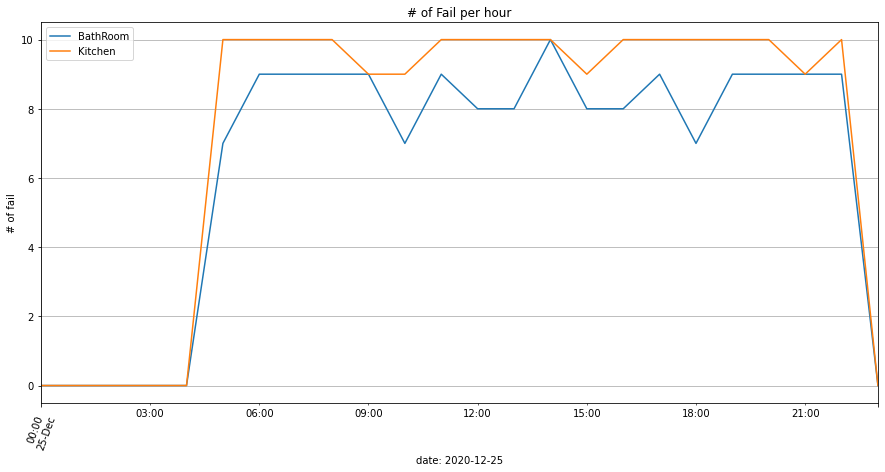

2020-12-26


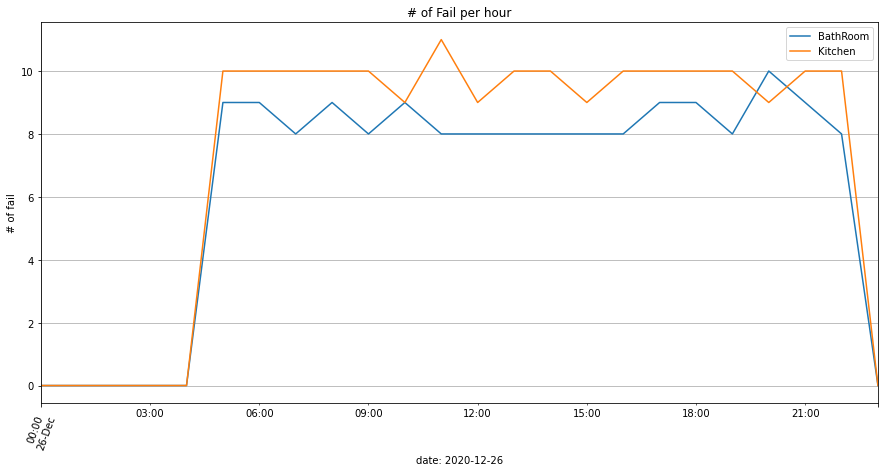

2020-12-27


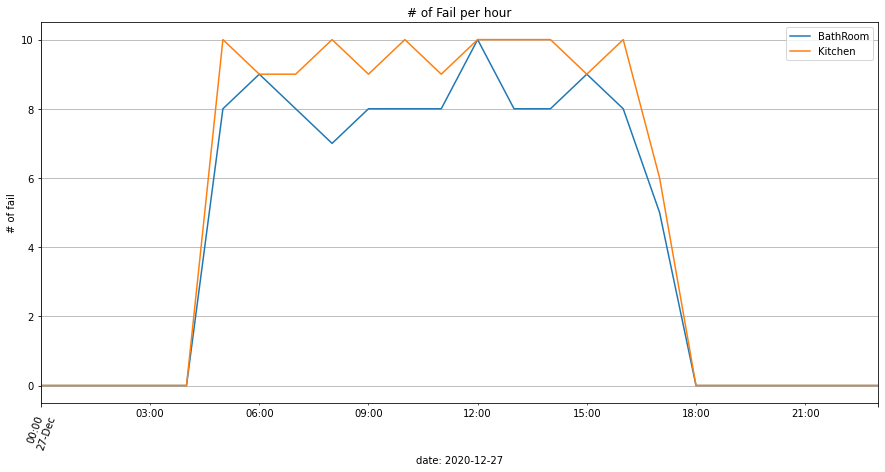

2020-12-28


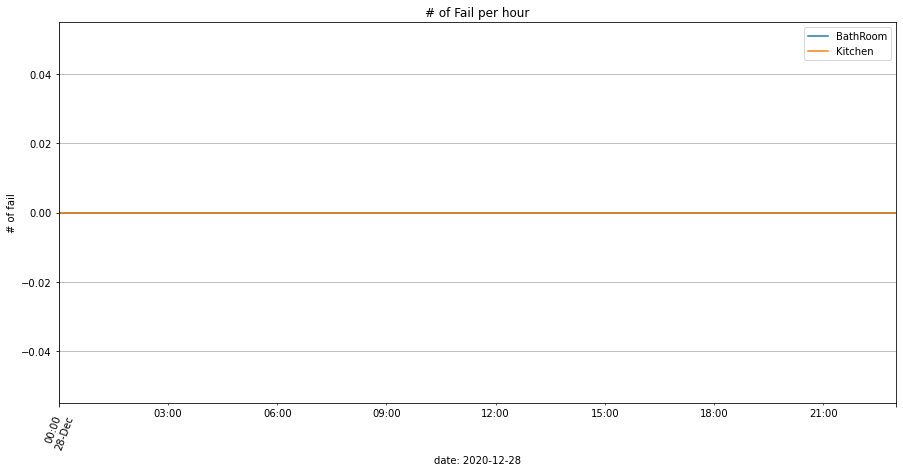

2020-12-29


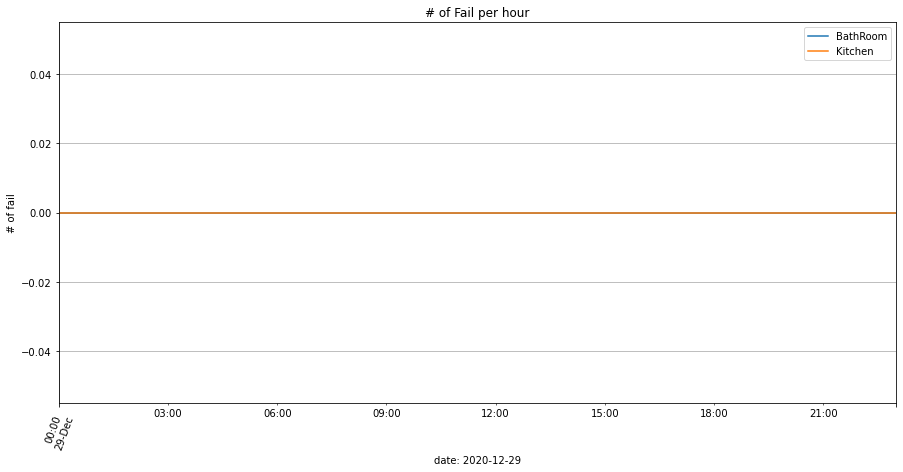

2020-12-30


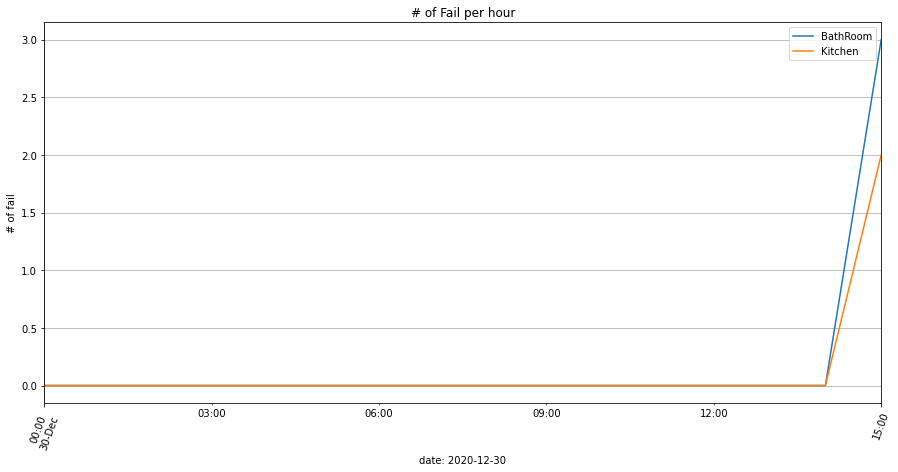

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


min_date, max_date = squeezeradio_logs_grouped.reset_index()['Date'].min(), squeezeradio_logs_grouped.reset_index()['Date'].max()
# min_date = min_date.strftime("%y-%m-%d")
min_date = min_date.strftime("%m/%d/%y")
max_date = max_date.strftime("%m/%d/%y")

iterate_index = pd.date_range(start=min_date, end=max_date)

#plot data

for day in iterate_index:
    fig, ax = plt.subplots(figsize=(15,7))
    day = day.strftime("%Y-%m-%d")
    print(day)
    squeezeradio_logs_grouped[day].plot(ax=ax);
    plt.xlabel('date: '+ day)
    plt.ylabel('# of fail')
    plt.title('# of Fail per hour')
    plt.grid(True)
    plt.xticks(rotation=70)    
    plt.show()
    filename=day+'.png'
    fig.savefig('plot/'+filename)



# Failure dataset, plot, and keep it

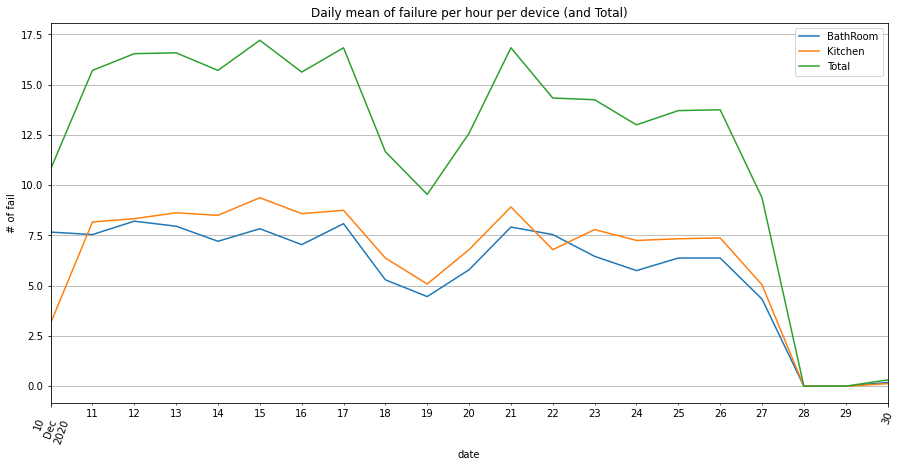

In [10]:
failure = squeezeradio_logs_grouped.resample("D").mean()
failure['Total']=failure['BathRoom']+failure['Kitchen']

fig, ax = plt.subplots(figsize=(15,7))



failure.plot(ax=ax)
plt.xlabel('date')
plt.ylabel('# of fail')
plt.title('Daily mean of failure per hour per device (and Total)')
plt.grid(True)
plt.xticks(rotation=70);
fig.savefig('plot/failure'+day+'.png')


# keep failure and squeezebox datasets

In [11]:
!mkdir -p 'dataset'

In [12]:
failure_name = 'failure.csv'
squeezebox_name = 'squeezebox.csv'

failure.to_csv('dataset/'+failure_name)
squeezeradio_logs_grouped.to_csv('dataset/'+squeezebox_name)